In [69]:
%pylab inline
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import datetime

Populating the interactive namespace from numpy and matplotlib


### 1. Выбор одной из зон среди отобранных на прошлой неделе и создание регрессионных признаков

In [70]:
# грузим заранее подготовленные аггрегированные данные время-поездки для 1281-го региона за первые 5 месяцев 2016 г.
raw = pd.read_csv('trips_1281.csv', sep=',')
# переводим столбцы времени в формат datetime
raw['time'] = pd.to_datetime(raw['time'])
raw.head()

,time,num_trips
0,2016-01-01 00:00:00,768.0
1,2016-01-01 01:00:00,1062.0
2,2016-01-01 02:00:00,1060.0
3,2016-01-01 03:00:00,614.0
4,2016-01-01 04:00:00,319.0


Text(0.5, 1.0, '1281-й регион')

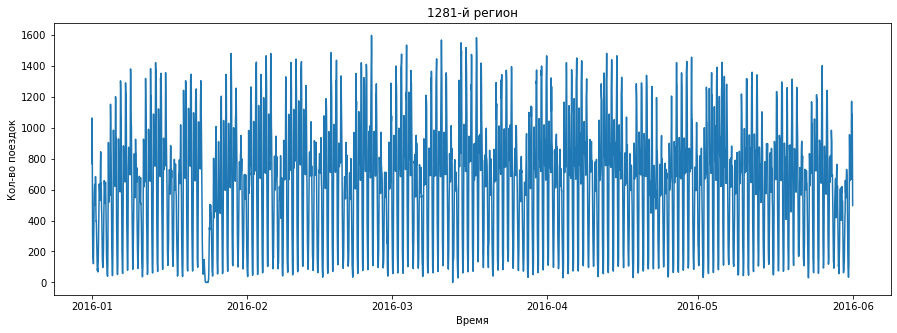

In [71]:
plt.figure(figsize=(15,5))
plt.plot(raw.time,raw.num_trips)
plt.ylabel("Кол-во поездок")
plt.xlabel("Время")
plt.title("1281-й регион")

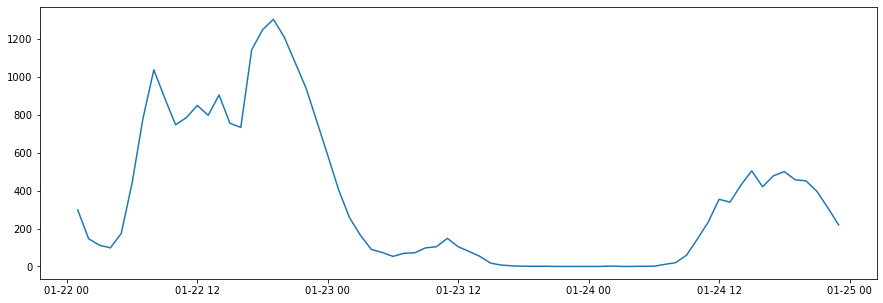

In [72]:
# смотрим ближе на место, где виден выброс
plt.figure(figsize=(15,5))
condition = (raw.time > datetime.datetime(2016, 1, 22)) & (raw.time < datetime.datetime(2016, 1, 25))
plt.plot(raw[condition].time,raw[condition].num_trips)

In [ ]:
# Три составляющие временного ряда:
# - сезонность (видна четко)
# - тренд (очень слабый)
# - выброс (~23-24.01)

# В идеале надо строить модель, заменять выбросовую область на модельный результат, после чего опять строить модель
# Эту процедуру можно применить несколько раз

In [73]:
data = raw.copy()

In [75]:
# Поскольку вдальнейшем мы будем использовать преобразование Бокса-Кокса для стабилизации дисперсии,
# необходимо добавить константу к поездкам дабы избежать нулевых значений (пр-е работает только с положительными значениями)
# добавим, например, 3
data['num_trips'] = data.apply(lambda x: x['num_trips']+3, axis = 1)

Если временной ряд $X$ условно считать функцией, то её возможно разложить в ряд Фурье:
$X(t) = \sum^n_{k=0}[a_kcos(\frac{2\pi}{n}kt)+b_ksin(\frac{2\pi}{n}kt)]$,

где $n$ играет роль выбираемой нами периодичности, выберем неделю, и, поскольку данные представлены в каждом часу,
$n = 24*7 = 168$

Таким образом, мы можем создать регрессионные переменные, которые для каждого значения $t$ будут являться 
значениями синусов и косинусов в приведенном выше разложении Фурье нашего ряда $X$. При этом надо понимать, 
что рассматривать все $n$ гармоник будет представлять слишком большую вычислительную сложность, да это и излишне,
поскольку мы строим всего лишь регрессионную модель, посему взятие первых $5-10$ гармоник будет достаточным.
Возьмем $8$ первых гармоник ($k=0...7$).

Но прежде чем создавать регрессионные переменные, необходимо представить время $t$ нашего ряда в виде номера часа начиная с 1

In [76]:
# вводим столбец, который и будет исполнять роль t
data['hour_num'] = range(1,data.shape[0]+1)
data.head()

,time,num_trips,hour_num
0,2016-01-01 00:00:00,771.0,1
1,2016-01-01 01:00:00,1065.0,2
2,2016-01-01 02:00:00,1063.0,3
3,2016-01-01 03:00:00,617.0,4
4,2016-01-01 04:00:00,322.0,5


Теперь создаём непосредственно признаки $c_k$ и $s_k$, $k = 1, ..., K$

In [77]:
K = 15
n = 168.0
for k in range(1,K+1):
    data["c" + str(k)] = np.cos(2*np.pi*k*np.arange(1, data.shape[0]+1)/n)
    data["s" + str(k)] = np.sin(2*np.pi*k*np.arange(1, data.shape[0]+1)/n)
data.head()

,time,num_trips,hour_num,c1,s1,c2,s2,c3,s3,c4,...,c11,s11,c12,s12,c13,s13,c14,s14,c15,s15
0,2016-01-01 00:00:00,771.0,1,0.999301,0.037391,0.997204,0.074730,0.993712,0.111964,0.988831,...,0.916562,0.399892,0.900969,0.433884,0.884115,0.467269,8.660254e-01,0.500000,0.846724,0.532032
1,2016-01-01 01:00:00,1065.0,2,0.997204,0.074730,0.988831,0.149042,0.974928,0.222521,0.955573,...,0.680173,0.733052,0.623490,0.781831,0.563320,0.826239,5.000000e-01,0.866025,0.433884,0.900969
2,2016-01-01 02:00:00,1063.0,3,0.993712,0.111964,0.974928,0.222521,0.943883,0.330279,0.900969,...,0.330279,0.943883,0.222521,0.974928,0.111964,0.993712,6.123234e-17,1.000000,-0.111964,0.993712
3,2016-01-01 03:00:00,617.0,4,0.988831,0.149042,0.955573,0.294755,0.900969,0.433884,0.826239,...,-0.074730,0.997204,-0.222521,0.974928,-0.365341,0.930874,-5.000000e-01,0.866025,-0.623490,0.781831
4,2016-01-01 04:00:00,322.0,5,0.982566,0.185912,0.930874,0.365341,0.846724,0.532032,0.733052,...,-0.467269,0.884115,-0.623490,0.781831,-0.757972,0.652287,-8.660254e-01,0.500000,-0.943883,0.330279


### 2. Сделаем регрессию целевого признака

In [78]:
# список столбцов - регрессионных признаков
regr_col = []
for i in range(1,K+1):
    regr_col.append('c' + str(i))
    regr_col.append('s' + str(i))

In [79]:
X = data[regr_col]
y = data['num_trips']

In [80]:
# Настраиваем линейную регрессионную модель
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

LinearRegression()

<AxesSubplot:>

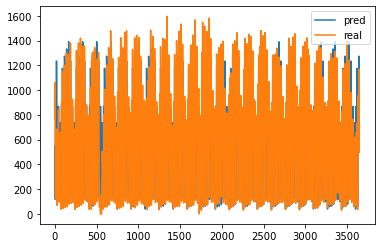

In [18]:
# Строим предсказания на имеющиеся данные, по которым и обучались
pred = pd.DataFrame({'pred':model.predict(X), 'real':y})
pred.plot()

<AxesSubplot:>

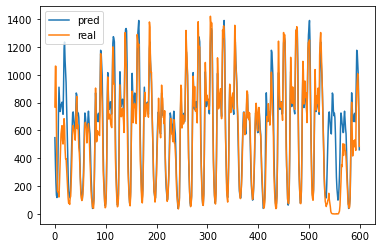

In [81]:
pred[pred.index<600].plot()

<AxesSubplot:>

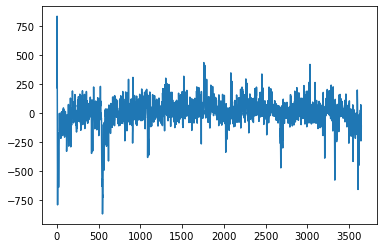

In [82]:
# остатки
resid = pred.real - pred.pred
resid.plot()

### 3. Подберите значения гиперпараметров ARIMA для ряда остатков

In [83]:
# приводим столбец остатков к нормальной форме датафрейма с временным индексом
residuals = raw.copy()
residuals.set_index('time',inplace=True)
for i in range(residuals.shape[0]):
    residuals.iloc[i] = resid[i]
residuals.head()

,num_trips
time,
2016-01-01 00:00:00,220.288211
2016-01-01 01:00:00,700.461762
2016-01-01 02:00:00,835.466531
2016-01-01 03:00:00,479.436239
2016-01-01 04:00:00,201.320254


Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. 
Если необходимо, сделайте несколько дифференцирований. 

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

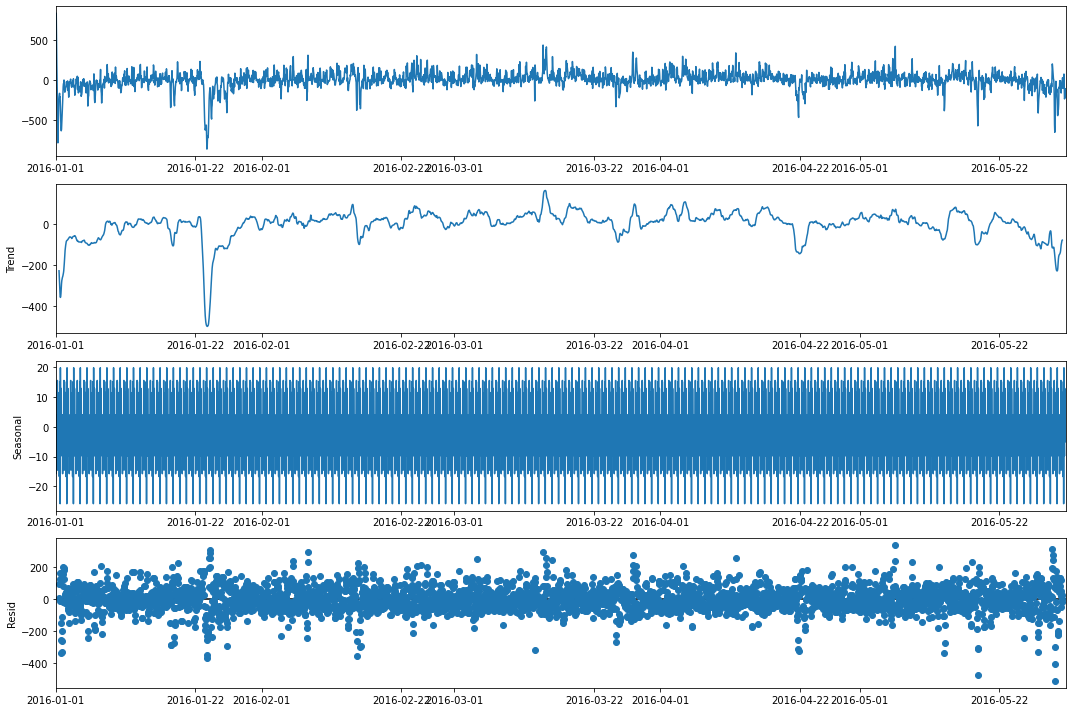

In [84]:
# Проверка стационарности и STL-декомпозиция ряда:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(residuals).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residuals)[1])

Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, 
что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, 
поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

Критерий Дики-Фуллера после сезонного и обычного дифф-я: p=0.000000


<Figure size 1080x720 with 0 Axes>

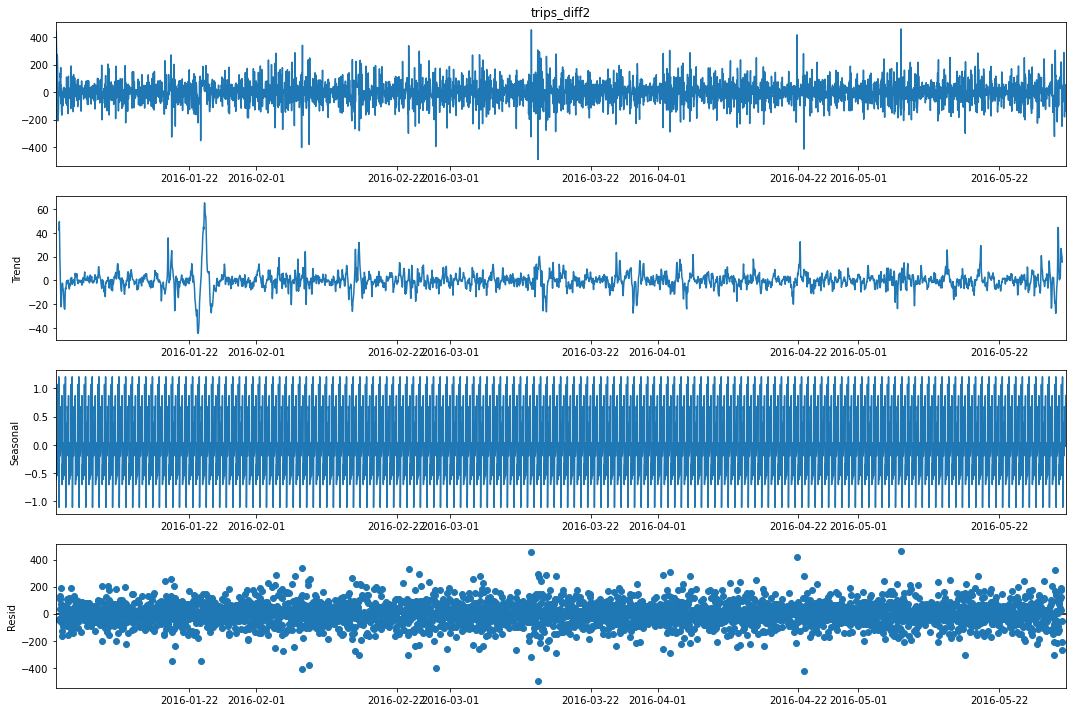

In [85]:
# Сначала дифференцирование по дням
residuals['trips_diff'] = residuals.num_trips - residuals.num_trips.shift(24)

# Добавляем дифференцирование продифференцированного по дням ряда по часам
residuals['trips_diff2'] = residuals.trips_diff - residuals.trips_diff.shift(1)

# Проверка стационарности и STL-декомпозиция ряда:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(residuals.trips_diff2[25:]).plot()
print("Критерий Дики-Фуллера после сезонного и обычного дифф-я: p=%f" % sm.tsa.stattools.adfuller(residuals.trips_diff2[25:])[1])

### 4. Подберите начальные приближения для параметров p, q, P, Q

Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки.

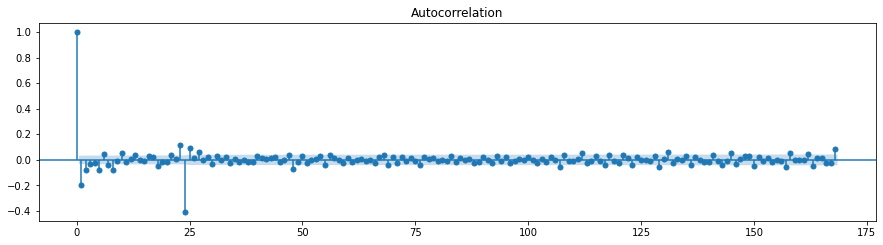

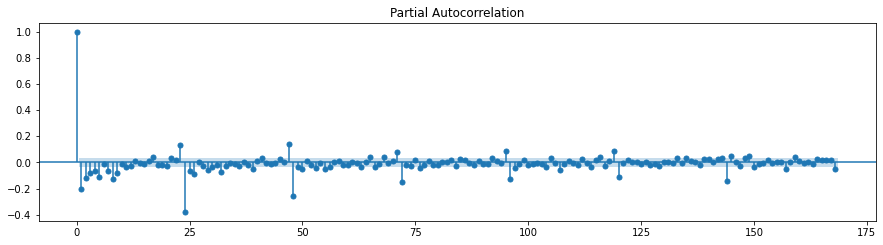

In [86]:
# Посмотрим на ACF и PACF полученного продифференцированного ряда остатков

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(residuals.trips_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(residuals.trips_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

In [87]:
# Параметры для поиска наилучшей модели SARIMA
from itertools import product

ps = range(0, 4)
d=1
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

Оптимальный параметр преобразования Бокса-Кокса: 0.734794
Критерий Дики-Фуллера после стабилизации: p=0.000000


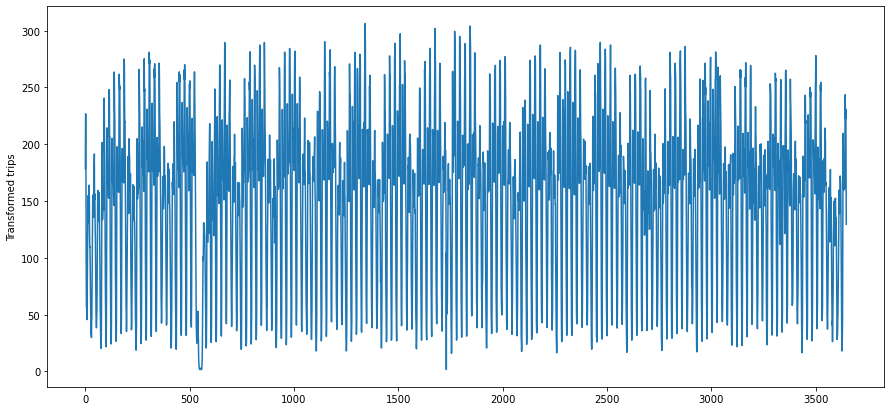

In [88]:
# преобразование Бокса-Кокса для стабилизации дисперсии, записываем в новый столбец 'trips_box'
data['trips_box'], lmbda = stats.boxcox(data.num_trips)
plt.figure(figsize(15,7))
data.trips_box.plot()
plt.ylabel(u'Transformed trips')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера после стабилизации: p=%f" % sm.tsa.stattools.adfuller(data.trips_box)[1])

In [96]:
%%time
# Подбор оптимальных параметров модели перебором
# exog=data[data.columns[3:]] - передача модели регрессионных признаков
import warnings

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

progress = 0
lenparam = len(parameters_list)
kpr = 0
i = -1

for param in parameters_list:
    print(param)
    i += 1
    progress = 100.0 * i/lenparam
    if (progress // 10) > kpr:
        kpr += 1
        print(progress,"% is done")
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.trips_box, exog=data[data.columns[3:data.shape[1]-1]],
                                        order=(param[0], d, param[1]), enforce_stationarity=False,
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)
10.9375 % is done
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 3, 0, 0)
(0, 3, 0, 1)
20.3125 % is done
(0, 3, 1, 0)
(0, 3, 1, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 1, 0, 0)
31.25 % is done
(1, 1, 0, 1)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 2, 0, 0)
(1, 2, 0, 1)
(1, 2, 1, 0)
40.625 % is done
(1, 2, 1, 1)
(1, 3, 0, 0)
(1, 3, 0, 1)
(1, 3, 1, 0)
(1, 3, 1, 1)
(2, 0, 0, 0)
50.0 % is done
(2, 0, 0, 1)
(2, 0, 1, 0)
(2, 0, 1, 1)
(2, 1, 0, 0)
(2, 1, 0, 1)
(2, 1, 1, 0)
(2, 1, 1, 1)
60.9375 % is done
(2, 2, 0, 0)
(2, 2, 0, 1)
(2, 2, 1, 0)
(2, 2, 1, 1)
(2, 3, 0, 0)
(2, 3, 0, 1)
70.3125 % is done
(2, 3, 1, 0)
(2, 3, 1, 1)
(3, 0, 0, 0)
(3, 0, 0, 1)
(3, 0, 1, 0)
(3, 0, 1, 1)
(3, 1, 0, 0)
81.25 % is done
(3, 1, 0, 1)
(3, 1, 1, 0)
(3, 1, 1, 1)
(3, 2, 0, 0)
(3, 2, 0, 1)
(3, 2, 1, 0)
90.625 % is done
(3, 2, 1, 1)
(3, 3, 0, 0)
(3, 3, 0, 1)
(3, 3, 1, 0)
(3, 3, 1, 1)
Wall time: 12h 

### 5. Выберите оптимальную по AIC модель

In [98]:
# Смотрим на параметры наилучших выбранных моделей
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
50  (3, 0, 1, 0)  30504.247829
13  (0, 3, 0, 1)  30704.147718
34  (2, 0, 1, 0)  30764.529673
18  (1, 0, 1, 0)  30907.122074
2   (0, 0, 1, 0)  30933.160242


In [99]:
# Выводим параметры лучшей модели
# в последнем блоке === === выводится инфа об остатках

print(best_model.summary())

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                     SARIMAX Results                                      
Dep. Variable:                          trips_box   No. Observations:                 3648
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -15217.124
Date:                            Sun, 20 Jun 2021   AIC                          30504.248
Time:                                    09:41:48   BIC                          30720.813
Sample:                                         0   HQIC                         30581.431
                                           - 3648                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c1            15.2504      9.300      1.640      0.101      -2.976      33.477
s1           -17.5077      9.308   

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.400432
Критерий Дики-Фуллера: p=0.000000


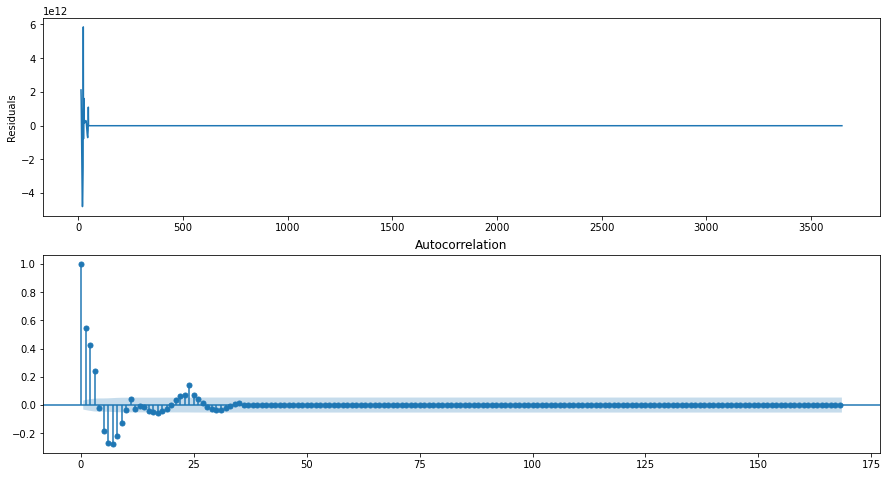

In [100]:
# проведем анализ остатков построенной модели
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])

In [ ]:
Остатки несмещены (подтверждается критерием Стьюдента, p > 0.05) 
стационарны (подтверждается критерием Дики-Фуллера, что, как писалось выше, не показательно, и визуально), 

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, '1281-й регион')

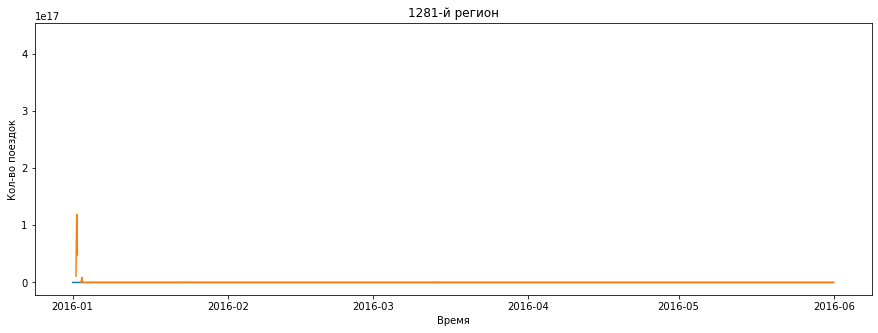

In [101]:
# сопоставляем модель с реальными данными

# Ф-ция обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

data['model'] = invboxcox(best_model.fittedvalues, lmbda)
#data['model'] = best_model.fittedvalues
# вычитаем 3 из каждого значения как оригинальных поездок, так и модельных (мы же прибавляли в начале 3)
data['num_trips'] = data.apply(lambda x: x['num_trips']-3, axis = 1)
data['model'] = data.apply(lambda x: x['model']-3, axis = 1)

plt.figure(figsize=(15,5))
plt.plot(data.time,data.num_trips,label = 'реальные')
plt.plot(data.time,data.model,label = 'модельные')
plt.ylabel("Кол-во поездок")
plt.xlabel("Время")
plt.title("1281-й регион")

#plt.figure(figsize(15,7))
#data.num_trips.plot()
#data.model[25:].plot(color='r')
#plt.ylabel('Кол-во поездок')
#pylab.show()

In [111]:
# Как видно ниже, модель неадекватна в самом начале, 1-е и 2-3 января и первые 2 часа 3 января
data.iloc[50].time

Timestamp('2016-01-03 02:00:00')

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, '1281-й регион')

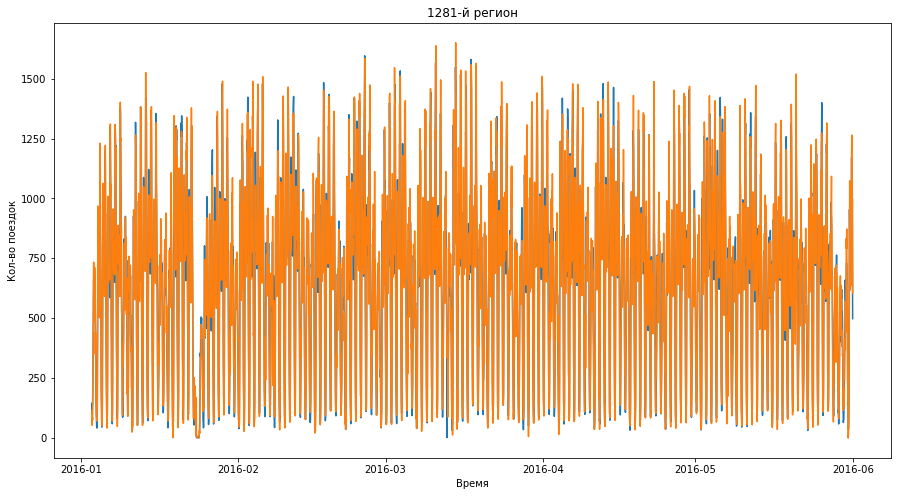

In [109]:
# поэтому, сопоставляем модель с реальными данными начиная с 03:00 3 января
cond = data.index>50

plt.plot(data[cond].time,data[cond].num_trips,label = 'реальные')
plt.plot(data[cond].time,data[cond].model,label = 'модельные')
plt.ylabel("Кол-во поездок")
plt.xlabel("Время")
plt.title("1281-й регион")

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


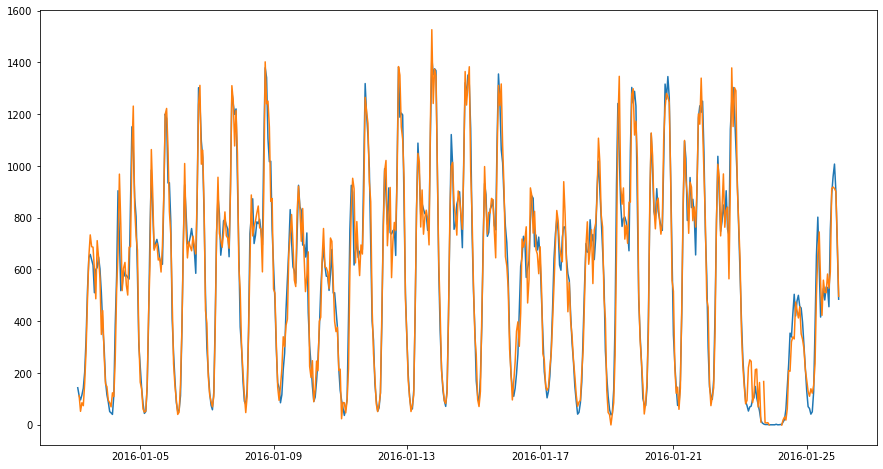

In [113]:
# смотрим на меньшем масштабе
win = (data.index>50) & (data.index<600)
plt.plot(data[win].time,data[win].num_trips,label = 'реальные')
plt.plot(data[win].time,data[win].model,label = 'модельные')

### 6. Проанализируйте качество построенной модели

Опишите, в какие периоды она плохо описывает данные? 
Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? 
Если да, попробуйте создать для таких периодов регрессионные признаки и перезапустите алгоритм.

In [ ]:
### Запись/Чтение модели SARIMAX

In [97]:
%%time
best_model.save('model.pkl')

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
from statsmodels.tsa.arima_model import ARIMAResults
# load model
loaded = ARIMAResults.load('model.pkl')

In [53]:
loaded

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


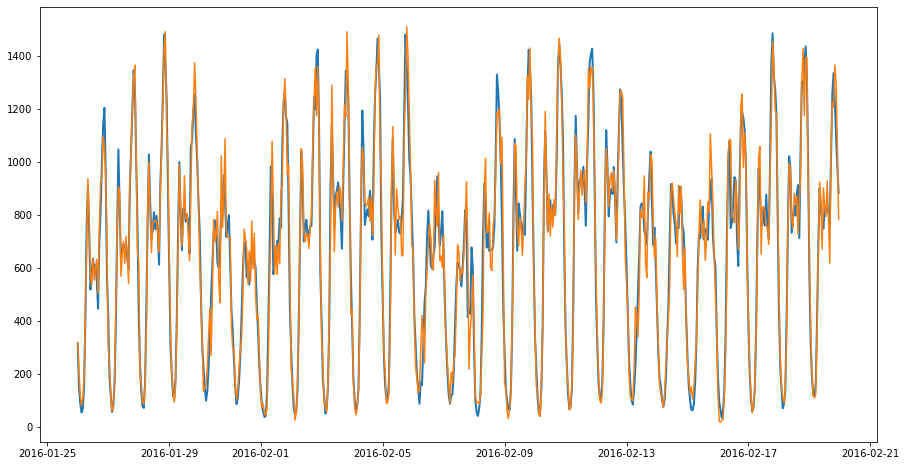

In [114]:
# смотрим на меньшем масштабе
win = (data.index>=600) & (data.index<1200)
plt.plot(data[win].time,data[win].num_trips,label = 'Real')
plt.plot(data[win].time,data[win].model,label = 'Model')

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


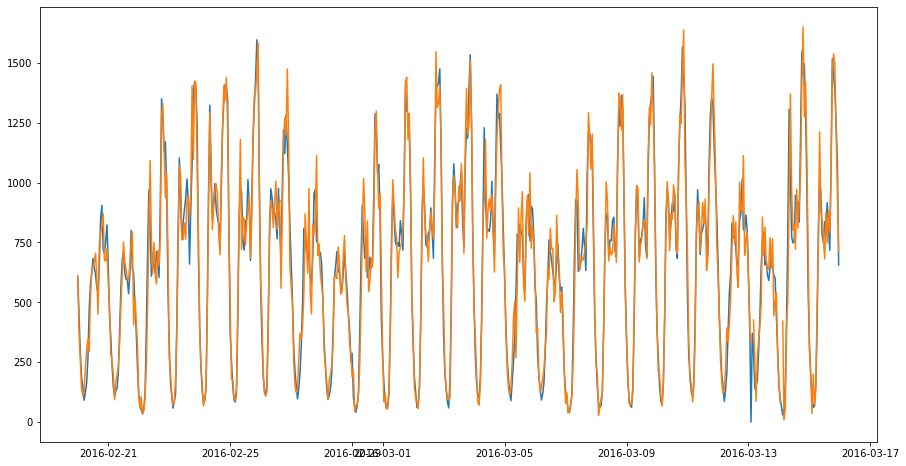

In [115]:
# смотрим на меньшем масштабе
win = (data.index>=1200) & (data.index<1800)
plt.plot(data[win].time,data[win].num_trips,label = 'Real')
plt.plot(data[win].time,data[win].model,label = 'Model')

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


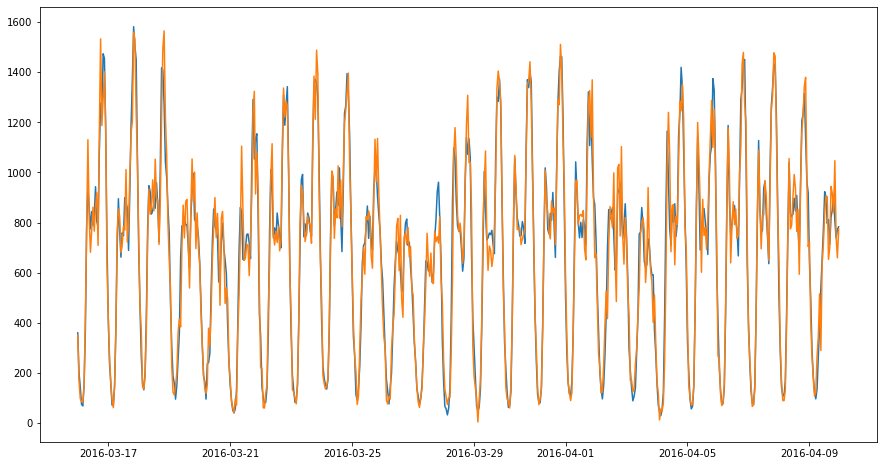

In [116]:
# смотрим на меньшем масштабе
win = (data.index>=1800) & (data.index<2400)
plt.plot(data[win].time,data[win].num_trips,label = 'Real')
plt.plot(data[win].time,data[win].model,label = 'Model')

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


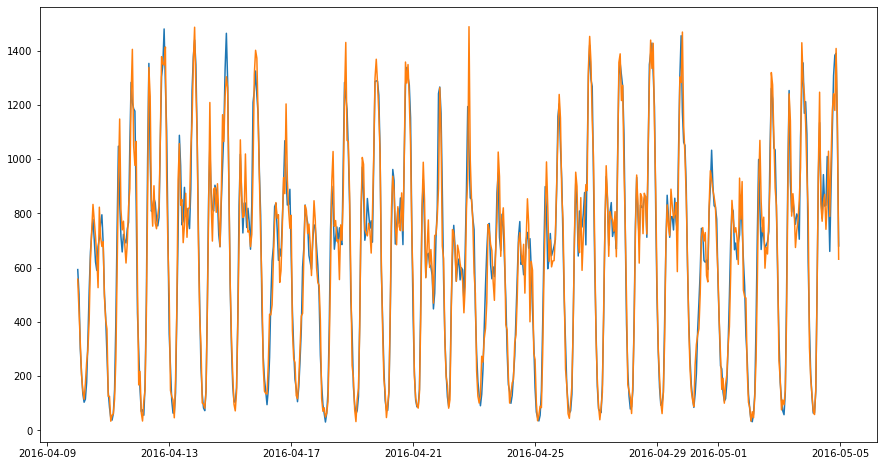

In [117]:
# смотрим на меньшем масштабе
win = (data.index>=2400) & (data.index<3000)
plt.plot(data[win].time,data[win].num_trips,label = 'Real')
plt.plot(data[win].time,data[win].model,label = 'Model')

C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


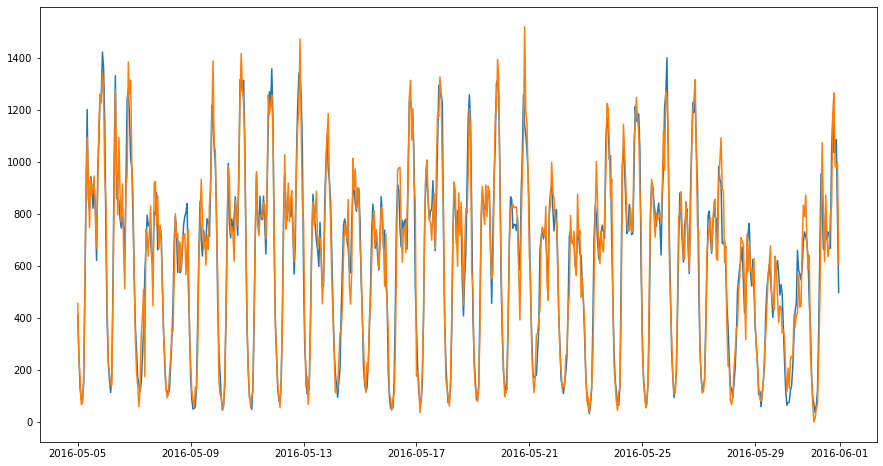

In [118]:
# смотрим на меньшем масштабе
win = data.index>=3000
plt.plot(data[win].time,data[win].num_trips,label = 'Real')
plt.plot(data[win].time,data[win].model,label = 'Model')

Таким образом, наша модель весьма неплохо сопоставляется с реальными данными, сильно ошибаясь 
только в начале 1-2 января, что видимо связано с дифференцированием ряда, а также аномальным поведением ряда в начале января